# Nome: Euline Marcos Rodrigues - RA: 850318

# IA369Y

# T3 - Análise e Síntese de Emoções em Conteúdo Multimídia

# Atividade 5 - Implementar um classificador de emoções para uma base específica

Esta atividade consiste em utilizar um corpus disponibilizado na disciplina IA369Y e implementar um classificador de emoções para esta base, baseado nos pontos característicos da face (“features” geométricos ou de “shape”). O corpus em questão, contém imagens da face de uma atriz expressando vários estados emocionais (23 ao todo) diferentes.

A atividade consiste em classificar quatro estados emocionais, além do estado neutro: “joy”, “anger”, “fear”, “sadness”. 

Junto a base de imagens, foi disponibilizado arquivo “imagedb_CH_disciplina.csv” que associa cada imagem a um rótulo emocional e também a coordenadas de pontos característicos da face.

Para a classificação decidi alterar o algoritmo proposto no tutorial de van Gent, P. (2016). Emotion Recognition Using Facial Landmarks, Python, DLib and OpenCV, disponível no site http://www.paulvangent.com/2016/08/05/emotion-recognition-using-facial-landmarks/. A última visualização do site para esta atividade foi em 16/11/2017.

Esta atividada foi realizada usando o Anaconda com Jupyter Notebook. 

Para garantir a estabilidade da instalação criei um ambiente protegido através do comando <i>source activate</i>. 

Nste ambiente o notebook é inicializado através do comando <i>jupyter notebook</i>.

O ambiente ficou assim, em relação aos principais pacotes (versões) utilizados:
- anaconda (<b>custom</b> / py35hd7b5ba2_0)  
- anaconda-client (<b>1.6.5 </b> / py35hf878a34_0)  
- boost (<b>1.59.0 </b> / py35_0    menpo)
- dlib (<b>1.4 </b> / py35_0    menpo)
- ipython (<b>6.1.0 </b> / py35h3f7db8a_1)  
- jupyter_client (<b>5.1.0 </b> / py35hfe06ecd_0)  
- jupyter_console (<b>5.2.0 </b> / py35hd2aa692_1)  
- jupyter_core (<b>4.3.0 </b> / py35h1d2ac15_0)  
- nltk (<b>3.2.4 </b> / py35hf54be8e_0)  
- notebook (<b>5.0.0 </b> / py35he0030f0_2)  
- numpy (<b>1.13.3</b> / py35hfd7066c_0)  
- opencv3 (<b>3.1.0</b> / py35_0 / menpo)
- pandas (<b>0.20.3</b> / py35h5e2f206_2)  
- python (<b>3.5.4</b>)  
- scikit-image (<b>0.13.0</b> / py35hf7e7ad6_1)  
- scikit-learn (<b>0.19.1</b> / py35h2b554eb_0) 
- scipy (<b>0.19.1</b>/ py35hf362045_3)

# Tratando arquivo CSV com informações do Corpus

O arquivo imagedb_CH_disciplica.csv contém as informações de todas as imagens, já com o rótulo da emoções identificado e 56 coordenadas de pontos característicos da face. Estes pontos serão utilizados como features para o algoritmo de classificação.

Este arquivo possui algumas colunas que não fazem sentido para esta atividade e as coordenadas estão agrupadas em colunas com o formato <i>(x ; y)</i>. 

Usando o programa Microsoft Excel e um editor Emacs, as colunas não utilizadas foram removidas e as informações de coordenadas foram divididas em dois campos cada. Este novo arquivo foi renomeado de <b><i>imagedb_CH_processed.csv</i></b>.

# Manipulando arquivo CSV com a biblioteca Pandas

O arquivo CSV foi aberto usando o pandas e acrescentados rótulos para as colunas, já que no arquivo original não havia nomes para as colunas. Observa-se também que no arquivo havia várias emoções além das 4 definidas.


In [3]:
import pandas as pd

file = pd.read_csv('Faces_Disciplina/imagedb_CH_processed.csv', header=None)

file[1].unique()


array(['admiration', 'anger', 'disapointment', 'disgust', 'fear',
       'fearsconfirmed', 'gloating', 'gratification', 'gratitude',
       'happyfor', 'hope', 'joy', 'love', 'neutral', 'pity', 'pride',
       'relief', 'remorse', 'reproach', 'ressentment', 'sadness',
       'satisfaction', 'shame'], dtype=object)

Os nomes dados foram:
- filename: nome do arquivo de imagem
- emotion: rótulo da emoção associada à imagem
- x1: coordenada x do ponto 1 da imagem
- y1: coordenada y do ponto 1 da imagem
- x2: coordenada x do ponto 2 da imagem
- y2: coordenada y do ponto 2 da imagem
- ...
- x56: coordenada x do ponto 56 da imagem
- y56: coordenada y do ponto 56 da imagem

Como só interessa as 4 emoções, um novo arquivo foi gerado com o Pandas com somente as emoções anger, joy, sadness, fear, além da situação sem emoção, neutral.


In [4]:
columns = []
columns.append('filename')
columns.append('emotion')
for i in range(1, 57):
    columns.append('x' + str(i))
    columns.append('y' + str(i))

file.columns = columns

file2 = file.loc[file['emotion'].isin(['neutral', 'joy', 'anger', 'fear', 'sadness'])]

file2['emotion'].unique()

array(['anger', 'fear', 'joy', 'neutral', 'sadness'], dtype=object)

# Rodando o classificador com os pontos do corpus fornecido

O código do tutorial do Paul van Gent foi alterado com as operações acima e com operações para usar os 56 pontos já fornecidos para cada imagem (features).

Foi usado o algoritmo linear SVM para treinar os dados obtidos.

O resultado desta execução pode ser visto abaixo.

In [1]:
import cv2
import glob
import random
import math
import numpy as np
import dlib
import itertools
import pandas as pd
from sklearn.svm import SVC

emotions = ["neutral", "anger", "joy", "fear", "sadness"]
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
clf = SVC(kernel='linear', probability=True, tol=1e-3)#, verbose = True) #Set the classifier as a support vector machines with polynomial kernel

data = {} #Make dictionary for all values

def read_file():
    file = pd.read_csv('Faces_Disciplina/imagedb_CH_processed.csv', header=None)
    columns = []
    columns.append('filename')
    columns.append('emotion')
    for i in range(1, 57):
        columns.append('x' + str(i))
        columns.append('y' + str(i))

    file.columns = columns
    file2 = file.loc[file['emotion'].isin(['neutral', 'joy', 'anger', 'fear', 'sadness'])]
    
    return file2
    
def get_files(emotion):
    #Define function to get file list, randomly shuffle it and split 80/20, usando Pandas

    files = file.loc[file['emotion'] == emotion]

    lim = np.random.rand(len(files)) < 0.80

    training = files[lim]
    prediction = files[~lim]

    return training, prediction

def get_landmarks(item):
    xlist = []
    ylist = []

    for col in range(2,item.size,2):
        xlist.append(item[col])
    for col in range(3,item.size,2):
        ylist.append(item[col])

    xmean = np.mean(xlist)
    ymean = np.mean(ylist)
    xcentral = [(x-xmean) for x in xlist]
    ycentral = [(y-ymean) for y in ylist]

    landmarks_vectorised = []

    for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
        landmarks_vectorised.append(w)
        landmarks_vectorised.append(z)
        meannp = np.asarray((ymean,xmean))
        coornp = np.asarray((z,w))
        dist = np.linalg.norm(coornp-meannp)

        landmarks_vectorised.append(dist)
        landmarks_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))
        
    data['landmarks_vectorised'] = landmarks_vectorised

    if (len(landmarks_vectorised)) < 1:
        data['landmarks_vectorised'] = "error"
        

def make_sets():
    training_data = []
    training_labels = []
    prediction_data = []
    prediction_labels = []
    for emotion in emotions:

        training, prediction = get_files(emotion)

#Append data to training and prediction list, and generate labels 0-7
        for it in range(len(training)):
            get_landmarks(training.iloc[it])
            if data['landmarks_vectorised'] == "error":
                print("no face detected on this one")
            else:
                training_data.append(data['landmarks_vectorised']) #append image array to training data list
                training_labels.append(emotions.index(emotion))


        for it in range(len(prediction)):
            get_landmarks(prediction.iloc[it])
            if data['landmarks_vectorised'] == "error":
                print("no face detected on this one")
            else:
                prediction_data.append(data['landmarks_vectorised']) #append image array to training data list
                prediction_labels.append(emotions.index(emotion))

    return training_data, training_labels, prediction_data, prediction_labels   
        
accur_lin = []
file = read_file()

for i in range(0,10):
    print("Making sets %s" %i) #Make sets by random sampling 80/20%
    training_data, training_labels, prediction_data, prediction_labels = make_sets()

    npar_train = np.array(training_data) #Turn the training set into a numpy array for the classifier
    npar_trainlabs = np.array(training_labels)
    print("training SVM linear %s" %i) #train SVM
    clf.fit(npar_train, training_labels)

    print("getting accuracies %s" %i) #Use score() function to get accuracy
    npar_pred = np.array(prediction_data)
    pred_lin = clf.score(npar_pred, prediction_labels)
    print ("linear: ", pred_lin)
    accur_lin.append(pred_lin) #Store accuracy in a list

print("Mean value linear SVM: %s" %np.mean(accur_lin)) #FGet mean accuracy of the 10 runs



Making sets 0
training SVM linear 0
getting accuracies 0
linear:  0.886363636364
Making sets 1
training SVM linear 1
getting accuracies 1
linear:  0.888888888889
Making sets 2
training SVM linear 2
getting accuracies 2
linear:  0.853658536585
Making sets 3
training SVM linear 3
getting accuracies 3
linear:  0.833333333333
Making sets 4
training SVM linear 4
getting accuracies 4
linear:  0.85
Making sets 5
training SVM linear 5
getting accuracies 5
linear:  0.816326530612
Making sets 6
training SVM linear 6
getting accuracies 6
linear:  0.973684210526
Making sets 7
training SVM linear 7
getting accuracies 7
linear:  0.867924528302
Making sets 8
training SVM linear 8
getting accuracies 8
linear:  0.878048780488
Making sets 9
training SVM linear 9
getting accuracies 9
linear:  0.953488372093
Mean value linear SVM: 0.880171681719


# Resultado com os pontos do corpus fornecido

O resultado obtido foi muito bom: <b>88.0%</b> de acurácia.

Contudo este resultado se deve a pequena quantidade de amostras fornecidas (195 ao todo, após a retiradas das emoções não consideradas). A quantidade de features também é muito próxima da sugerida no tutorial (68 pontos), o que a torna significativa para ser usada pelo classificador.

# Rodando o classificador conforme sugerido no tutorial citado

Como as imagens também foram fornecidas, foi também feitas as mesmas operações do tutorial citado.

Para isto, foi criada a mesma estrutura de diretórios sugerida e um script para copiar somentes as imagens fornecidas pelo corpus para a esta estrutura:


#!/bin/bash
cp Em22_Fala1_0049_640x480.png ../sorted_set/anger/
cp Em22_Fala3_0041_640x480.png ../sorted_set/anger/
cp Em22_Fala1_0165_640x480.png ../sorted_set/anger/
cp Em22_Fala2_0166_640x480.png ../sorted_set/anger/
cp Em22_Fala3_0292_640x480.png ../sorted_set/anger/
cp Em22_Fala3_0346_640x480.png ../sorted_set/anger/
cp Em22_Fala1_0085_640x480.png ../sorted_set/anger/
cp Em22_Fala1_0040_640x480.png ../sorted_set/anger/
cp Em22_Fala1_0033_640x480.png ../sorted_set/anger/
cp Em22_Fala2_0188_640x480.png ../sorted_set/anger/
cp Em22_Fala2_0197_640x480.png ../sorted_set/anger/
cp Em22_Fala2_0174_640x480.png ../sorted_set/anger/
cp Em22_Fala3_0003_640x480.png ../sorted_set/anger/
cp Em22_Fala1_0106_640x480.png ../sorted_set/anger/
cp Em22_Fala3_0277_640x480.png ../sorted_set/anger/
cp Em22_Fala1_0073_640x480.png ../sorted_set/anger/
cp Em22_Fala3_0193_640x480.png ../sorted_set/anger/
cp Em22_Fala3_0095_640x480.png ../sorted_set/anger/
cp Em22_Fala3_0246_640x480.png ../sorted_set/anger/
cp Em22_Fala3_0180_640x480.png ../sorted_set/anger/
cp Em22_Fala3_0024_640x480.png ../sorted_set/anger/
cp Em22_Fala1_0092_640x480.png ../sorted_set/anger/
cp Em22_Fala3_0288_640x480.png ../sorted_set/anger/
cp Em22_Fala1_0132_640x480.png ../sorted_set/anger/
cp Em22_Fala3_0261_640x480.png ../sorted_set/anger/
cp Em22_Fala2_0099_640x480.png ../sorted_set/anger/
cp Em22_Fala3_0091_640x480.png ../sorted_set/anger/
cp Em22_Fala2_0095_640x480.png ../sorted_set/anger/
cp Em22_Fala2_0268_640x480.png ../sorted_set/anger/
cp Em22_Fala1_0212_640x480.png ../sorted_set/anger/
cp Em22_Fala3_0316_640x480.png ../sorted_set/anger/
cp Em22_Fala2_0289_640x480.png ../sorted_set/anger/
cp Em22_Fala3_0031_640x480.png ../sorted_set/anger/
cp Em22_Fala2_0294_640x480.png ../sorted_set/anger/
cp Em22_Fala3_0113_640x480.png ../sorted_set/anger/
cp Em22_Fala3_0127_640x480.png ../sorted_set/anger/
cp Em22_Fala1_0145_640x480.png ../sorted_set/anger/
cp Em22_Fala1_0037_640x480.png ../sorted_set/anger/
cp Em22_Fala1_0254_640x480.png ../sorted_set/anger/
cp Em13_Fala1_0081_640x480.png ../sorted_set/fear/
cp Em13_Fala3_0391_640x480.png ../sorted_set/fear/
cp Em13_Fala3_0053_640x480.png ../sorted_set/fear/
cp Em13_Fala1_0335_640x480.png ../sorted_set/fear/
cp Em13_Fala2_0261_640x480.png ../sorted_set/fear/
cp Em13_Fala2_0144_640x480.png ../sorted_set/fear/
cp Em13_Fala2_0158_640x480.png ../sorted_set/fear/
cp Em13_Fala3_0474_640x480.png ../sorted_set/fear/
cp Em13_Fala2_0150_640x480.png ../sorted_set/fear/
cp Em13_Fala1_0471_640x480.png ../sorted_set/fear/
cp Em13_Fala1_0078_640x480.png ../sorted_set/fear/
cp Em13_Fala1_0447_640x480.png ../sorted_set/fear/
cp Em13_Fala2_0029_640x480.png ../sorted_set/fear/
cp Em13_Fala2_0241_640x480.png ../sorted_set/fear/
cp Em13_Fala3_0315_640x480.png ../sorted_set/fear/
cp Em13_Fala2_0123_640x480.png ../sorted_set/fear/
cp Em13_Fala3_0298_640x480.png ../sorted_set/fear/
cp Em13_Fala1_0462_640x480.png ../sorted_set/fear/
cp Em13_Fala2_0073_640x480.png ../sorted_set/fear/
cp Em13_Fala2_0094_640x480.png ../sorted_set/fear/
cp Em13_Fala2_0139_640x480.png ../sorted_set/fear/
cp Em13_Fala2_0091_640x480.png ../sorted_set/fear/
cp Em13_Fala1_0032_640x480.png ../sorted_set/fear/
cp Em13_Fala2_0237_640x480.png ../sorted_set/fear/
cp Em13_Fala1_0146_640x480.png ../sorted_set/fear/
cp Em13_Fala2_0136_640x480.png ../sorted_set/fear/
cp Em13_Fala1_0274_640x480.png ../sorted_set/fear/
cp Em13_Fala1_0027_640x480.png ../sorted_set/fear/
cp Em13_Fala2_0143_640x480.png ../sorted_set/fear/
cp Em13_Fala2_0221_640x480.png ../sorted_set/fear/
cp Em13_Fala1_0221_640x480.png ../sorted_set/fear/
cp Em13_Fala2_0107_640x480.png ../sorted_set/fear/
cp Em13_Fala3_0038_640x480.png ../sorted_set/fear/
cp Em13_Fala3_0111_640x480.png ../sorted_set/fear/
cp Em13_Fala3_0305_640x480.png ../sorted_set/fear/
cp Em13_Fala1_0071_640x480.png ../sorted_set/fear/
cp Em13_Fala1_0301_640x480.png ../sorted_set/fear/
cp Em13_Fala1_0074_640x480.png ../sorted_set/fear/
cp Em13_Fala1_0401_640x480.png ../sorted_set/fear/
cp Em12_Fala1_0129_640x480.png ../sorted_set/sadness/
cp Em12_Fala3_0409_640x480.png ../sorted_set/sadness/
cp Em12_Fala2_0337_640x480.png ../sorted_set/sadness/
cp Em12_Fala1_0231_640x480.png ../sorted_set/sadness/
cp Em12_Fala1_0467_640x480.png ../sorted_set/sadness/
cp Em12_Fala1_0470_640x480.png ../sorted_set/sadness/
cp Em12_Fala2_0218_640x480.png ../sorted_set/sadness/
cp Em12_Fala1_0164_640x480.png ../sorted_set/sadness/
cp Em12_Fala1_0461_640x480.png ../sorted_set/sadness/
cp Em12_Fala2_0450_640x480.png ../sorted_set/sadness/
cp Em12_Fala1_0126_640x480.png ../sorted_set/sadness/
cp Em12_Fala3_0294_640x480.png ../sorted_set/sadness/
cp Em12_Fala3_0540_640x480.png ../sorted_set/sadness/
cp Em12_Fala3_0310_640x480.png ../sorted_set/sadness/
cp Em12_Fala1_0385_640x480.png ../sorted_set/sadness/
cp Em12_Fala3_0301_640x480.png ../sorted_set/sadness/
cp Em12_Fala2_0344_640x480.png ../sorted_set/sadness/
cp Em12_Fala3_0153_640x480.png ../sorted_set/sadness/
cp Em12_Fala2_0444_640x480.png ../sorted_set/sadness/
cp Em12_Fala2_0612_640x480.png ../sorted_set/sadness/
cp Em12_Fala1_0364_640x480.png ../sorted_set/sadness/
cp Em12_Fala3_0099_640x480.png ../sorted_set/sadness/
cp Em12_Fala1_0072_640x480.png ../sorted_set/sadness/
cp Em12_Fala1_0543_640x480.png ../sorted_set/sadness/
cp Em12_Fala3_0398_640x480.png ../sorted_set/sadness/
cp Em12_Fala1_0374_640x480.png ../sorted_set/sadness/
cp Em12_Fala3_0474_640x480.png ../sorted_set/sadness/
cp Em12_Fala1_0065_640x480.png ../sorted_set/sadness/
cp Em12_Fala1_0368_640x480.png ../sorted_set/sadness/
cp Em12_Fala2_0425_640x480.png ../sorted_set/sadness/
cp Em12_Fala2_0359_640x480.png ../sorted_set/sadness/
cp Em12_Fala2_0623_640x480.png ../sorted_set/sadness/
cp Em12_Fala1_0157_640x480.png ../sorted_set/sadness/
cp Em12_Fala3_0112_640x480.png ../sorted_set/sadness/
cp Em12_Fala2_0221_640x480.png ../sorted_set/sadness/
cp Em12_Fala1_0119_640x480.png ../sorted_set/sadness/
cp Em12_Fala1_0245_640x480.png ../sorted_set/sadness/
cp Em12_Fala1_0068_640x480.png ../sorted_set/sadness/
cp Em12_Fala3_0058_640x480.png ../sorted_set/sadness/
cp Em2_Fala1_0064_640x480.png ../sorted_set/joy/
cp Em2_Fala2_0097_640x480.png ../sorted_set/joy/
cp Em2_Fala1_0317_640x480.png ../sorted_set/joy/
cp Em2_Fala3_0373_640x480.png ../sorted_set/joy/
cp Em2_Fala3_0313_640x480.png ../sorted_set/joy/
cp Em2_Fala1_0275_640x480.png ../sorted_set/joy/
cp Em2_Fala2_0163_640x480.png ../sorted_set/joy/
cp Em2_Fala1_0126_640x480.png ../sorted_set/joy/
cp Em2_Fala3_0306_640x480.png ../sorted_set/joy/
cp Em2_Fala1_0367_640x480.png ../sorted_set/joy/
cp Em2_Fala1_0093_640x480.png ../sorted_set/joy/
cp Em2_Fala3_0377_640x480.png ../sorted_set/joy/
cp Em2_Fala2_0019_640x480.png ../sorted_set/joy/
cp Em2_Fala3_0392_640x480.png ../sorted_set/joy/
cp Em2_Fala3_0256_640x480.png ../sorted_set/joy/
cp Em2_Fala3_0383_640x480.png ../sorted_set/joy/
cp Em2_Fala1_0257_640x480.png ../sorted_set/joy/
cp Em2_Fala1_0362_640x480.png ../sorted_set/joy/
cp Em2_Fala3_0078_640x480.png ../sorted_set/joy/
cp Em2_Fala2_0268_640x480.png ../sorted_set/joy/
cp Em2_Fala1_0269_640x480.png ../sorted_set/joy/
cp Em2_Fala1_0163_640x480.png ../sorted_set/joy/
cp Em2_Fala1_0063_640x480.png ../sorted_set/joy/
cp Em2_Fala3_0153_640x480.png ../sorted_set/joy/
cp Em2_Fala2_0275_640x480.png ../sorted_set/joy/
cp Em2_Fala1_0335_640x480.png ../sorted_set/joy/
cp Em2_Fala2_0308_640x480.png ../sorted_set/joy/
cp Em2_Fala1_0056_640x480.png ../sorted_set/joy/
cp Em2_Fala1_0273_640x480.png ../sorted_set/joy/
cp Em2_Fala1_0185_640x480.png ../sorted_set/joy/
cp Em2_Fala1_0154_640x480.png ../sorted_set/joy/
cp Em2_Fala3_0339_640x480.png ../sorted_set/joy/
cp Em2_Fala1_0114_640x480.png ../sorted_set/joy/
cp Em2_Fala3_0162_640x480.png ../sorted_set/joy/
cp Em2_Fala1_0339_640x480.png ../sorted_set/joy/
cp Em2_Fala1_0084_640x480.png ../sorted_set/joy/
cp Em2_Fala1_0251_640x480.png ../sorted_set/joy/
cp Em2_Fala1_0060_640x480.png ../sorted_set/joy/
cp Em2_Fala3_0323_640x480.png ../sorted_set/joy/
cp Em6_Fala1_Neutra_0300_640x480.png ../sorted_set/neutral/
cp Em6_Fala1_Neutra_0295_640x480.png ../sorted_set/neutral/
cp Em6_Fala1_Neutra_0444_640x480.png ../sorted_set/neutral/
cp Em6_Fala1_Neutra_0374_640x480.png ../sorted_set/neutral/
cp Em6_Fala2_Neutra_0037_640x480.png ../sorted_set/neutral/
cp Em6_Fala1_Neutra_0060_640x480.png ../sorted_set/neutral/
cp Em6_Fala1_Neutra_0258_640x480.png ../sorted_set/neutral/
cp Em6_Fala1_Neutra_0409_640x480.png ../sorted_set/neutral/
cp Em6_Fala2_Neutra_0031_640x480.png ../sorted_set/neutral/
cp Em6_Fala2_Neutra_0356_640x480.png ../sorted_set/neutral/
cp Em6_Fala2_Neutra_0309_640x480.png ../sorted_set/neutral/
cp Em6_Fala1_Neutra_0249_640x480.png ../sorted_set/neutral/
cp Expressao_Neutra_0020_640x480.png ../sorted_set/neutral/
cp Em6_Fala2_Neutra_0380_640x480.png ../sorted_set/neutral/
cp Em6_Fala1_Neutra_0149_640x480.png ../sorted_set/neutral/
cp Em6_Fala1_Neutra_0512_640x480.png ../sorted_set/neutral/
cp Em6_Fala1_Neutra_0285_640x480.png ../sorted_set/neutral/
cp Em6_Fala1_Neutra_0193_640x480.png ../sorted_set/neutral/
cp Em6_Fala1_Neutra_0245_640x480.png ../sorted_set/neutral/
cp Em6_Fala1_Neutra_0271_640x480.png ../sorted_set/neutral/
cp Em6_Fala1_Neutra_0258_640x480.png ../sorted_set/neutral/
cp Em6_Fala1_Neutra_0090_640x480.png ../sorted_set/neutral/
cp Em6_Fala1_Neutra_0370_640x480.png ../sorted_set/neutral/
cp Em6_Fala1_Neutra_0356_640x480.png ../sorted_set/neutral/
cp Em6_Fala1_Neutra_0057_640x480.png ../sorted_set/neutral/
cp Em6_Fala1_Neutra_0143_640x480.png ../sorted_set/neutral/
cp Em6_Fala2_Neutra_0395_640x480.png ../sorted_set/neutral/
cp Em6_Fala1_Neutra_0049_640x480.png ../sorted_set/neutral/
cp Em6_Fala1_Neutra_0262_640x480.png ../sorted_set/neutral/
cp Em6_Fala2_Neutra_0219_640x480.png ../sorted_set/neutral/
cp Em6_Fala1_Neutra_0454_640x480.png ../sorted_set/neutral/
cp Em6_Fala1_Neutra_0096_640x480.png ../sorted_set/neutral/
cp Em6_Fala1_Neutra_0130_640x480.png ../sorted_set/neutral/
cp Em6_Fala2_Neutra_0383_640x480.png ../sorted_set/neutral/
cp Em6_Fala2_Neutra_0334_640x480.png ../sorted_set/neutral/
cp Em6_Fala1_Neutra_0524_640x480.png ../sorted_set/neutral/
cp Em6_Fala1_Neutra_0380_640x480.png ../sorted_set/neutral/
cp Em6_Fala1_Neutra_0053_640x480.png ../sorted_set/neutral/
cp Em6_Fala1_Neutra_0420_640x480.png ../sorted_set/neutral/


# Rodando o classificador conforme o tutorial citado

Nesta execução as imagens foram tratadas para ficarem do mesmo tamanho, em tons de cinza e somente o rosto. Os pontos usados para classificação foram os fornecidos pelo arquivo <i>shape_predictor_68_face_landmarks.dat</i>.

Também foi usado o algoritmo linear SVM para treinar os dados obtidos de cada imagem.

O resultado desta execução pode ser visto abaixo.

In [2]:
import cv2
import glob
import random
import math
import numpy as np
import dlib
import itertools
from sklearn.svm import SVC

emotions = ["neutral", "anger", "joy", "fear", "sadness"]
clahe = cv2.createCLAHE(clipLimit=2.0, tileGridSize=(8,8))
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("shape_predictor_68_face_landmarks.dat") #Or set this to whatever you named the downloaded file
clf = SVC(kernel='linear', probability=True, tol=1e-3)#, verbose = True) #Set the classifier as a support vector machines with polynomial kernel

data = {} #Make dictionary for all values
#data['landmarks_vectorised'] = []

def get_files(emotion): #Define function to get file list, randomly shuffle it and split 80/20
    files = glob.glob("dataset//%s//*" %emotion)
    random.shuffle(files)
    training = files[:int(len(files)*0.8)] #get first 80% of file list
    prediction = files[-int(len(files)*0.2):] #get last 20% of file list
    return training, prediction

def get_landmarks(image):
    detections = detector(image, 1)
    for k,d in enumerate(detections): #For all detected face instances individually
        shape = predictor(image, d) #Draw Facial Landmarks with the predictor class
        xlist = []
        ylist = []
        for i in range(1,68): #Store X and Y coordinates in two lists
            xlist.append(float(shape.part(i).x))
            ylist.append(float(shape.part(i).y))
            
        xmean = np.mean(xlist)
        ymean = np.mean(ylist)
        xcentral = [(x-xmean) for x in xlist]
        ycentral = [(y-ymean) for y in ylist]

        landmarks_vectorised = []
        for x, y, w, z in zip(xcentral, ycentral, xlist, ylist):
            landmarks_vectorised.append(w)
            landmarks_vectorised.append(z)
            meannp = np.asarray((ymean,xmean))
            coornp = np.asarray((z,w))
            dist = np.linalg.norm(coornp-meannp)
            landmarks_vectorised.append(dist)
            landmarks_vectorised.append((math.atan2(y, x)*360)/(2*math.pi))

        data['landmarks_vectorised'] = landmarks_vectorised
    if len(detections) < 1: 
        data['landmarks_vestorised'] = "error"

def make_sets():
    training_data = []
    training_labels = []
    prediction_data = []
    prediction_labels = []
    for emotion in emotions:
        print(" working on %s" %emotion)
        training, prediction = get_files(emotion)
        #Append data to training and prediction list, and generate labels 0-7
        for item in training:
            image = cv2.imread(item) #open image
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY) #convert to grayscale
            clahe_image = clahe.apply(gray)
            get_landmarks(clahe_image)
            if data['landmarks_vectorised'] == "error":
                print("no face detected on this one")
            else:
                training_data.append(data['landmarks_vectorised']) #append image array to training data list
                training_labels.append(emotions.index(emotion))
    
        for item in prediction:
            image = cv2.imread(item)
            gray = cv2.cvtColor(image, cv2.COLOR_BGR2GRAY)
            clahe_image = clahe.apply(gray)
            get_landmarks(clahe_image)
            if data['landmarks_vectorised'] == "error":
                print("no face detected on this one")
            else:
                prediction_data.append(data['landmarks_vectorised'])
                prediction_labels.append(emotions.index(emotion))

    return training_data, training_labels, prediction_data, prediction_labels   

accur_lin = []
for i in range(0,10):
    print("Making sets %s" %i) #Make sets by random sampling 80/20%
    training_data, training_labels, prediction_data, prediction_labels = make_sets()

    npar_train = np.array(training_data) #Turn the training set into a numpy array for the classifier
    npar_trainlabs = np.array(training_labels)
    print("training SVM linear %s" %i) #train SVM
    clf.fit(npar_train, training_labels)

    print("getting accuracies %s" %i) #Use score() function to get accuracy
    npar_pred = np.array(prediction_data)
    pred_lin = clf.score(npar_pred, prediction_labels)
    print ("linear: ", pred_lin)
    accur_lin.append(pred_lin) #Store accuracy in a list

print("Mean value lin svm: %s" %np.mean(accur_lin)) #FGet mean accuracy of the 10 runs


Making sets 0
 working on neutral
 working on anger
 working on joy
 working on fear
 working on sadness
training SVM linear 0
getting accuracies 0
linear:  0.685714285714
Making sets 1
 working on neutral
 working on anger
 working on joy
 working on fear
 working on sadness
training SVM linear 1
getting accuracies 1
linear:  0.771428571429
Making sets 2
 working on neutral
 working on anger
 working on joy
 working on fear
 working on sadness
training SVM linear 2
getting accuracies 2
linear:  0.857142857143
Making sets 3
 working on neutral
 working on anger
 working on joy
 working on fear
 working on sadness
training SVM linear 3
getting accuracies 3
linear:  0.714285714286
Making sets 4
 working on neutral
 working on anger
 working on joy
 working on fear
 working on sadness
training SVM linear 4
getting accuracies 4
linear:  0.742857142857
Making sets 5
 working on neutral
 working on anger
 working on joy
 working on fear
 working on sadness
training SVM linear 5
getting accur

# Resultado com os pontos conforme o tutorial citado

O resultado obtido foi abaixo: <b>76.3%</b> de acurácia.

Como o resultado ficou abaixo inclusive do tutorial, presumo que o classificador também não conseguiu amostras suficientes para treinar e obter melhores resultados. Também presumo que as features fornecidas pelo corpus melhor definiram cada emoção considerada do que os 68 pontos de landmarks fornecido no tutorial.

Exemplos de algumas imagens com landmarks obtidas para imagens com emoções <i> joy, anger</i> e <i>fear</i>:


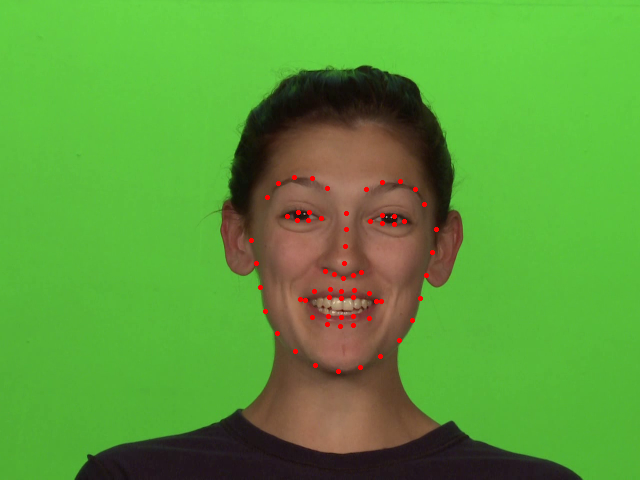

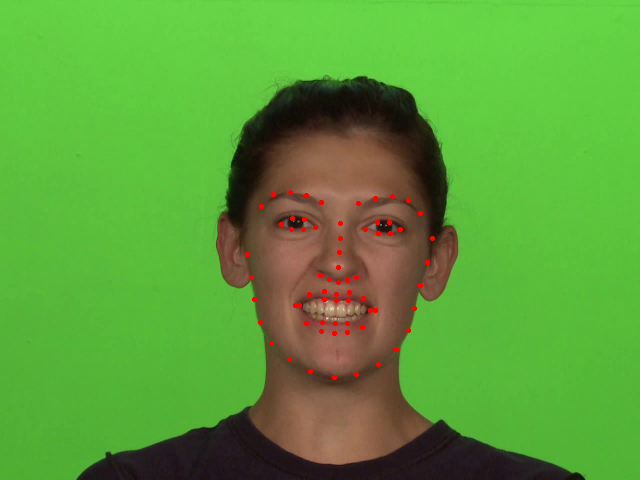

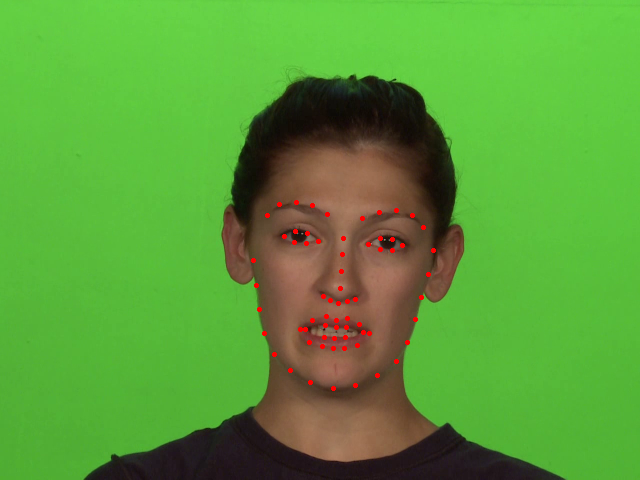

In [1]:
from IPython.display import Image, display
display(Image(filename='joy_68d.png', embed=True))
display(Image(filename='anger_68d.png', embed=True))
display(Image(filename='fear_68d.png', embed=True))

# Resultados

Foi importante observar que o volume de amostras é relevante quando se deseja treinar um classificador. A escolha das features também pode influenciar o resultado final.

Em se tratando do assunto emoções definir quais emoções serão consideradas é um ponto importante. Este é um aprendizado que a disciplina trouxe. Uma lição: menos é mais talvez favoreça o pioneiro Paul Ekman que definiu poucas emoções como básicas e o que vier daí, tem como matriz geradora a emoção básica.

Isto mostra que o encontrar datasets com amostras suficientes também é muito importante.

Outro aprendizado que ficou foi o uso do Pandas para manipular arquivos e tratá-los como bases relacionais.